In [1]:
# coding: utf-8
import numpy as np, os, pickle, gzip
import matplotlib as mpl, matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib import cm
from numpy import linalg as LA
from sklearn import tree
mpl.rcParams['figure.figsize'] = (20.0, 10.0)

from kalman import KalmanFilter
KITTI_HOME = '/home/kreimer/KITTI'

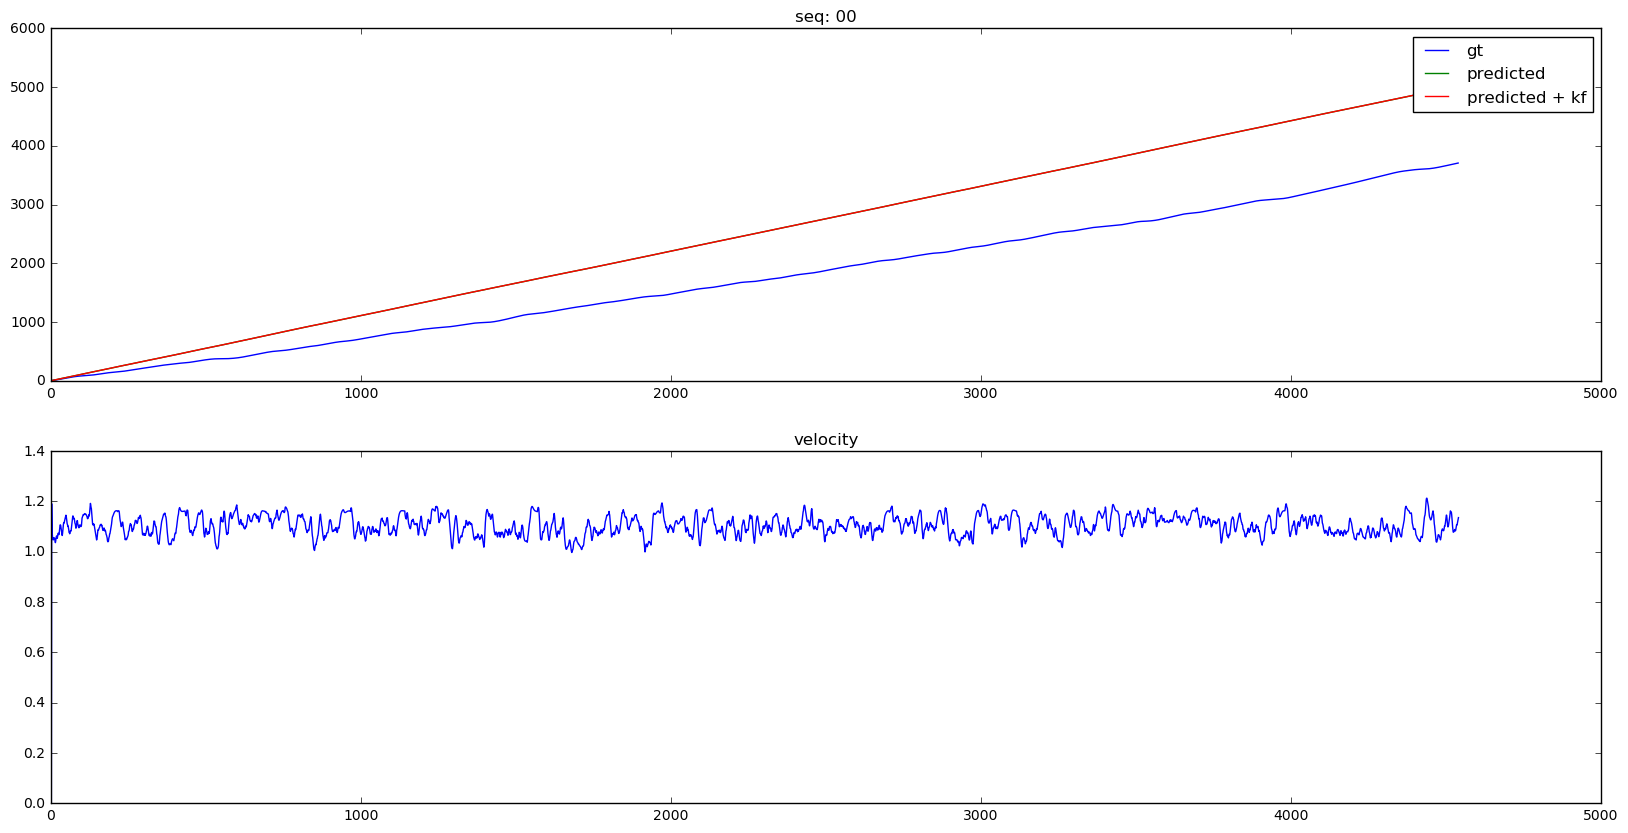

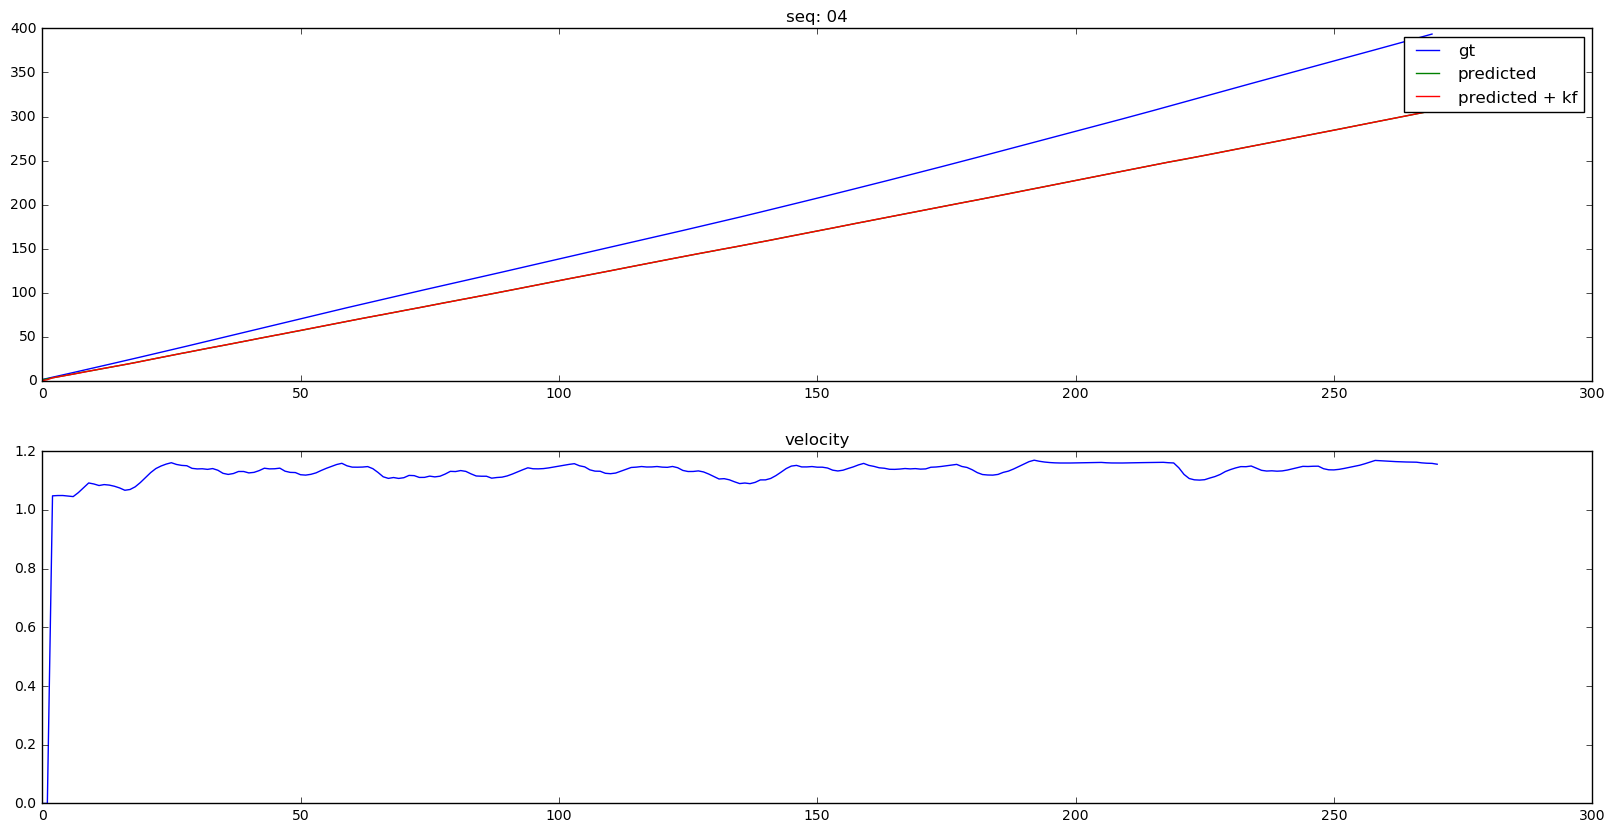

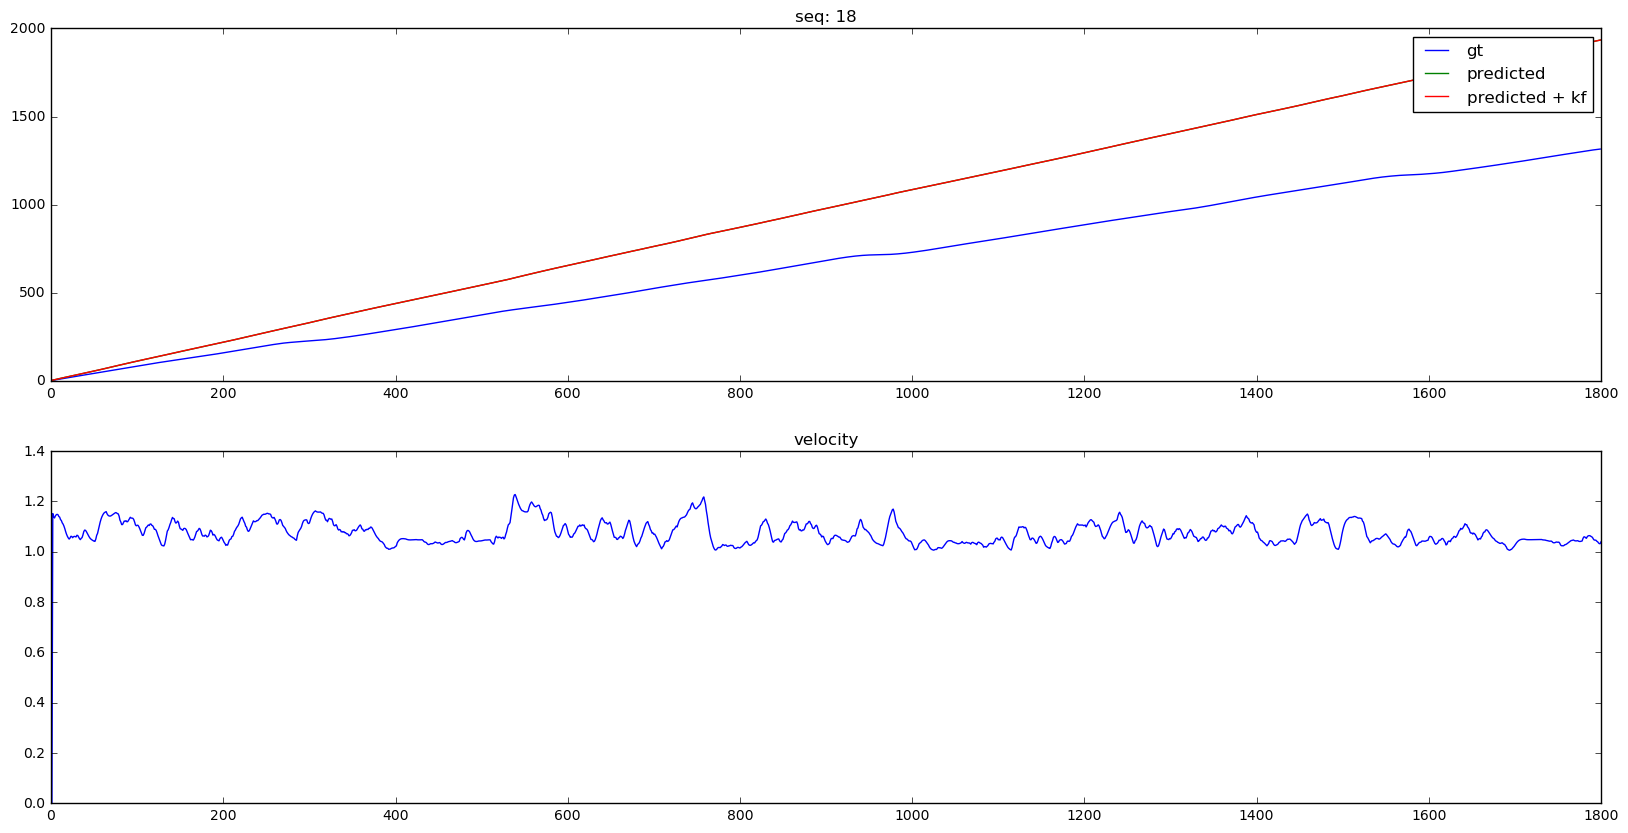

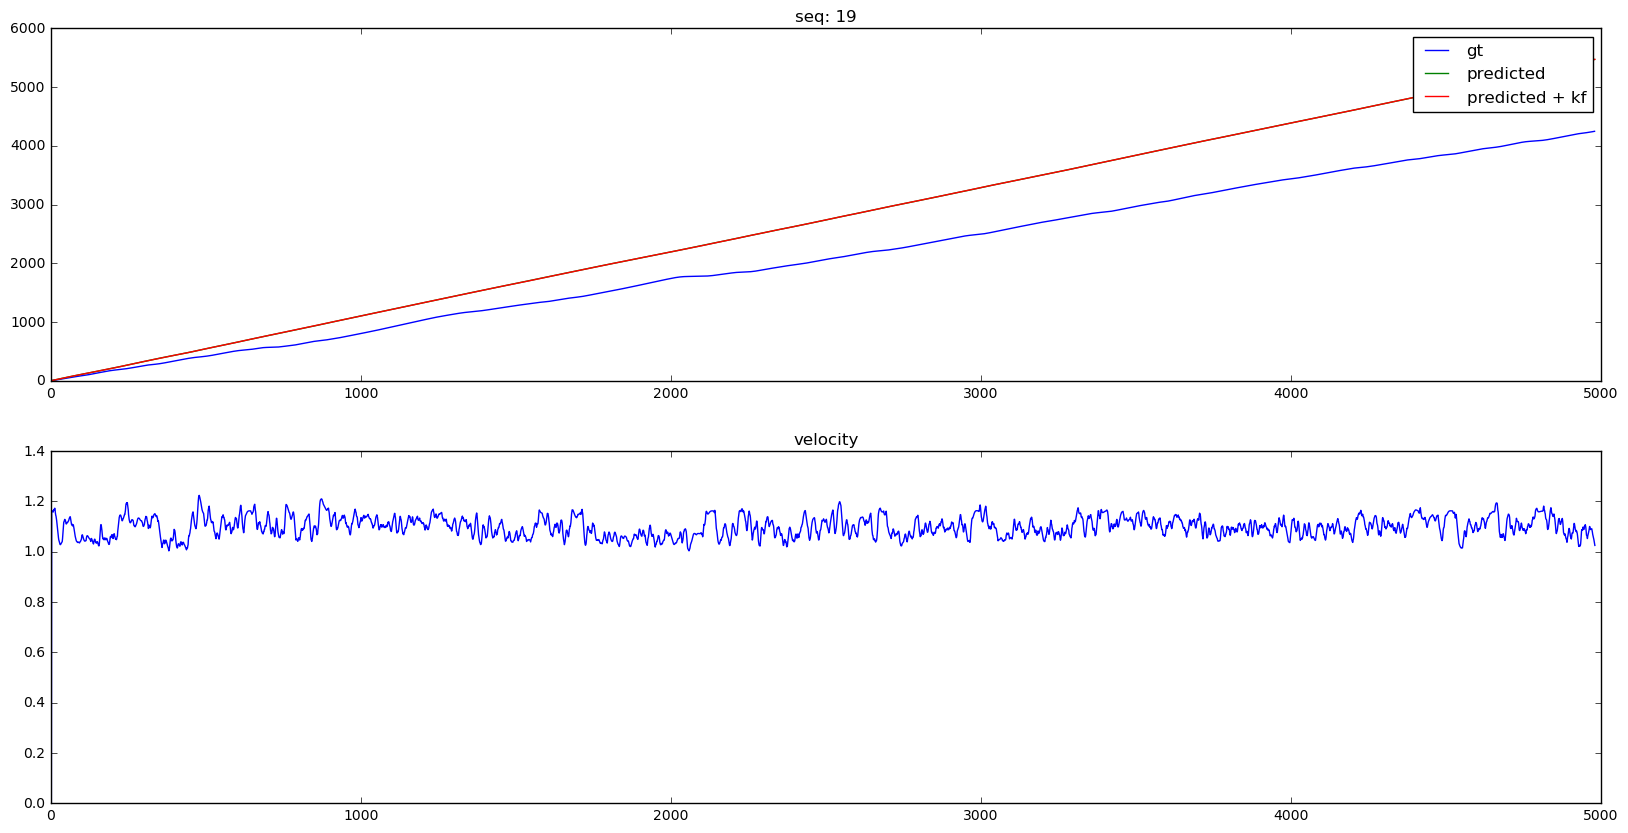

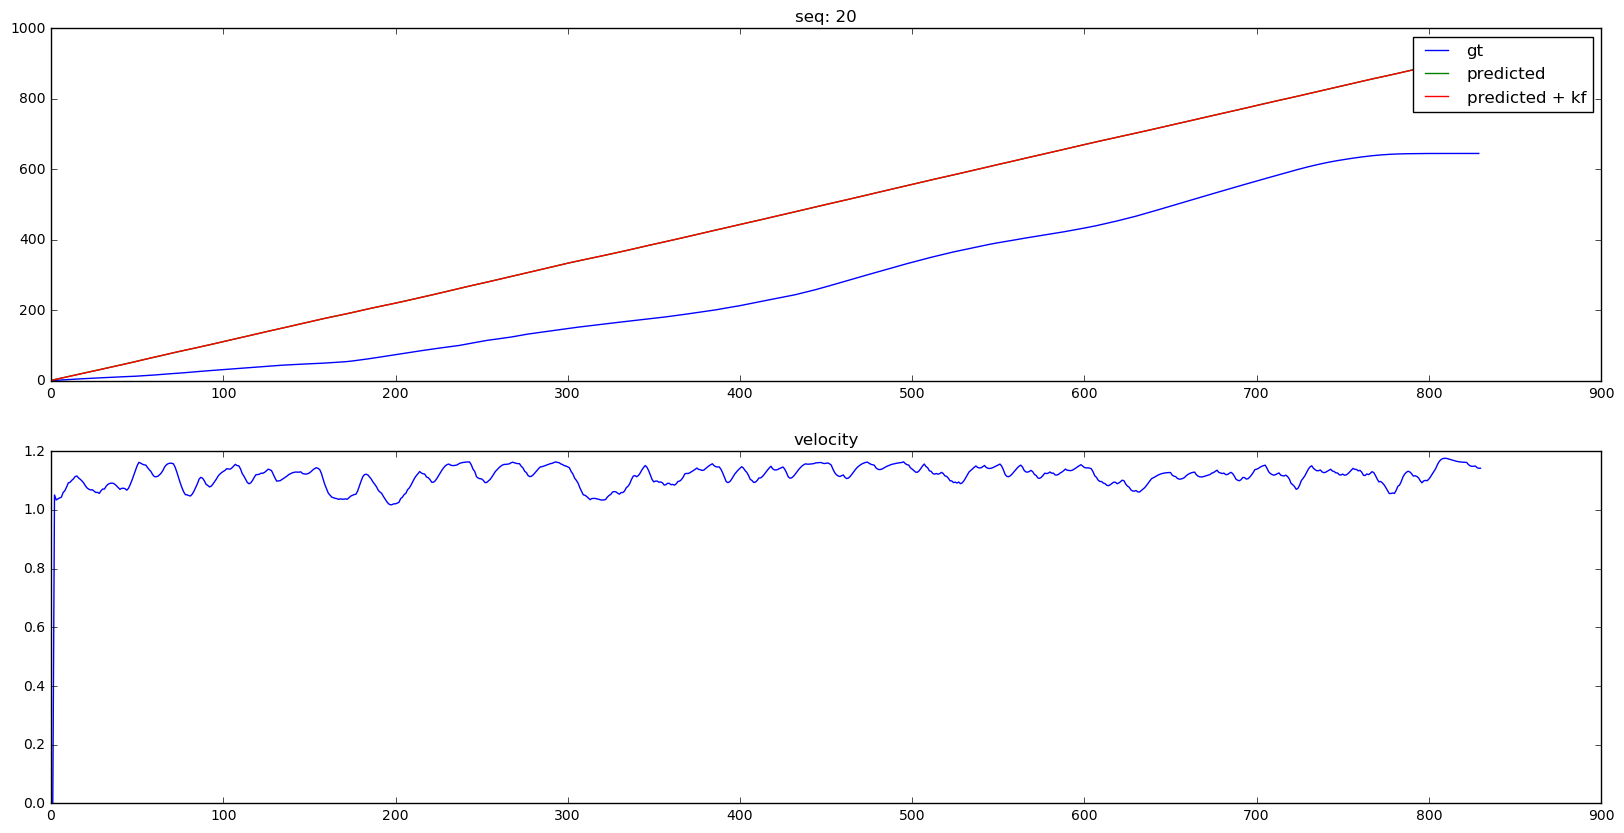

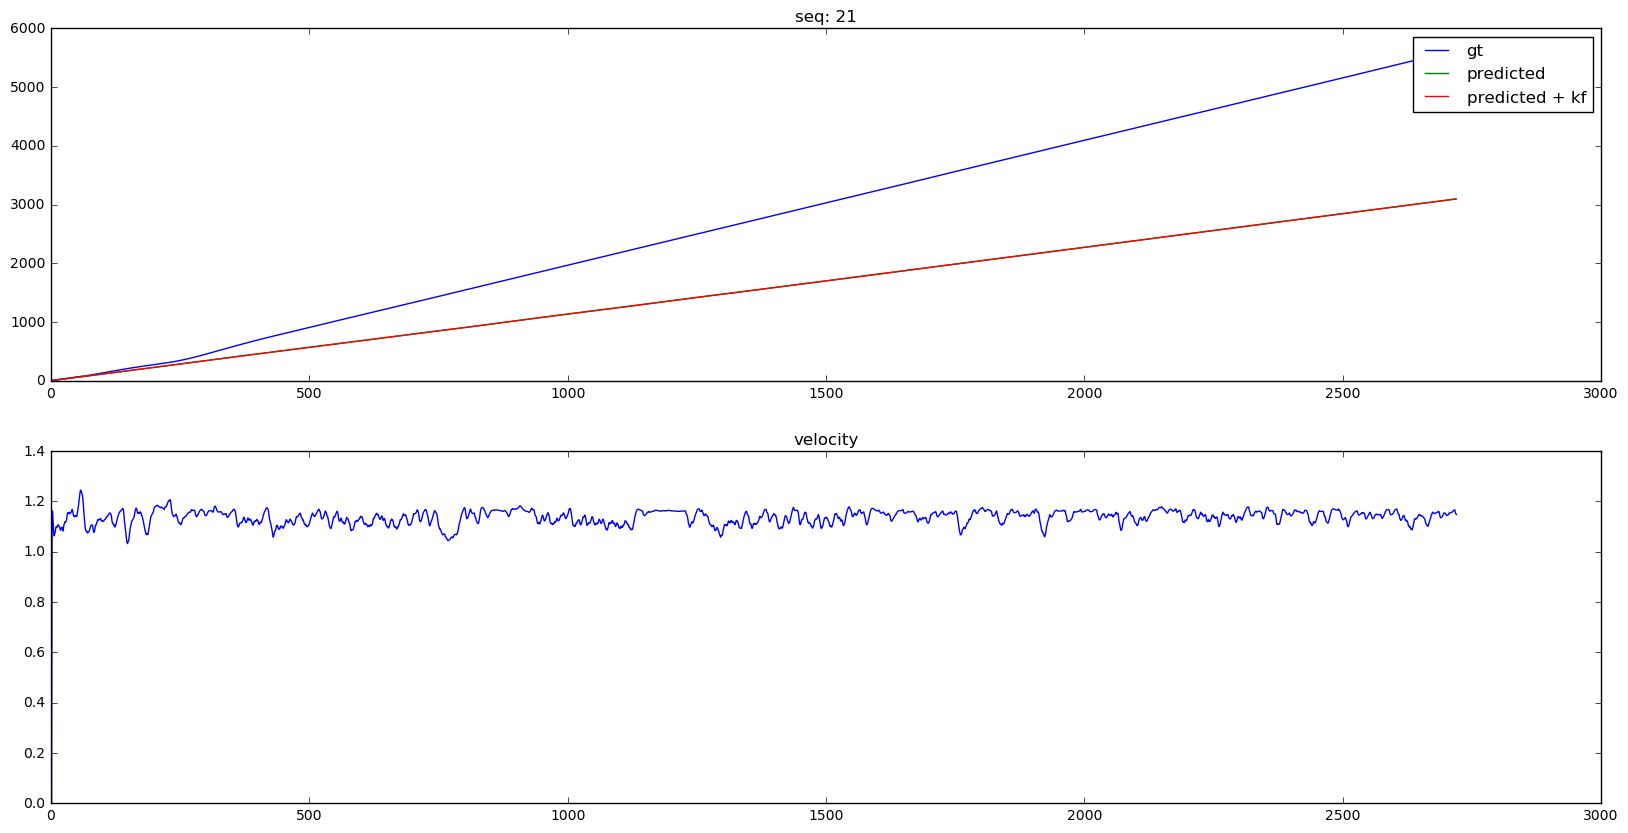

In [2]:
def plot_results(seq, dt, dt_pred, pred_kalman):
    plt.subplot(211)
    dt_pred_kalman = [float(pred[0]) for pred in pred_kalman]
    velocity_kf = [float(pred[1]) for pred in pred_kalman]
    line_dt, = plt.plot(dt, label='gt')
    line_dt_pred, = plt.plot(dt_pred, label='predicted')
    line_dt_pred_kf, = plt.plot(dt_pred_kalman, label='predicted + kf')
    plt.legend(handles=[line_dt, line_dt_pred, line_dt_pred_kf, ])
    plt.title('seq: %s' % seq)
    plt.subplot(212)
    plt.plot(velocity_kf)
    plt.title('velocity')
    return

def read_dts(file):
    dts, xyz = [], []
    with open(file, 'r') as f:
        for num, line in enumerate(f):
            pose = np.array([float(val) for val in line.split()]).reshape(3,4)
            pose = np.vstack((pose, [0, 0, 0, 1]))
            xyz.append(pose[:3,3])
            try:
                delta = np.dot(LA.inv(ppose), pose)
            except NameError:
                ppose = pose
                continue
            dt = delta[:3,3]
            dts.append(dt)

            ppose = pose
    return dts, xyz

def load_dataset(seq):
    # load the precomputed features
    with gzip.open(os.path.join('data', 'features', '%s_1_6_3_300.pklz' % seq), 'rb') as fd:
        pairs, feat, xyz = pickle.load(fd)
    return [np.linalg.norm(dt) for dt in xyz], feat, xyz

def load_model():
    # load the model
    with gzip.open(os.path.join('data', 'models', 'ETR_1_6_3_300.pklz'), 'rb') as fd:
        rf = pickle.load(fd)
    return rf
    
def predict_kalman_seq(seq, feat):
    rf = load_model()
    X = np.array(feat)
    pred = np.cumsum(rf.predict(X))
    x = np.array([[0.], [0.]]) # initial state (location and velocity)
    P = np.array([[1000., 0.], [0., 1000.]]) # initial uncertainty
    
    # constant acceleration model
    dt = 1.
    G = np.array([[dt*dt/2], [dt]])
    sigma_a = 0.1;
    Q = sigma_a*sigma_a;

    kf = KalmanFilter(Q=Q, G=G)
    pred_kf = [x]
    xabs = 0
    for measurement in pred:
        x, P = kf.step(x, P, measurement)
        pred_kf.append(x)
    return pred, pred_kf

for seq in ['00', '04', '18', '19', '20', '21']:
    plt.figure()
    dt, feat, xyz = load_dataset(seq)
    pred, pred_kf = predict_kalman_seq(seq, feat)
    plot_results(seq, np.cumsum(dt), pred, pred_kf)
plt.show()